<a href="https://colab.research.google.com/github/Harold-Rodriguez/ECG/blob/main/Project_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%reset

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_data = '/content/drive/MyDrive/11_MAS2/ECG/data'

y = pd.read_csv(f'{path_data}/annotations/gold_standard.csv')
y.rename(columns={'1dAVb': 'dAVb'}, inplace=True)
with h5py.File(f"{path_data}/ecg_tracings.hdf5", "r") as f:
  x = np.array(f['tracings'])
np.random.seed(123)

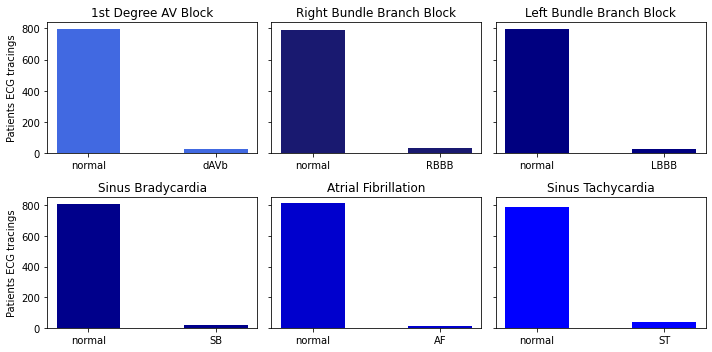

In [ ]:
n_bins = 200
labels= ['normal']
labels.extend(y.columns)
label = 3
axes=np.array([2, 3])
colors=['royalblue', 'midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue']
titles = ['1st Degree AV Block', 'Right Bundle Branch Block', 'Left Bundle Branch Block', 'Sinus Bradycardia', 'Atrial Fibrillation', 'Sinus Tachycardia']
fig, axs = plt.subplots(2, 3, figsize=(10,5), tight_layout=True, sharey='row')
axs[0, 0].set_ylabel('Patients ECG tracings')
axs[1, 0].set_ylabel('Patients ECG tracings') 
for i in range(axes[0]) :
  label*=i
  for n in range(axes[1]):
    axs[i, n].bar((labels[0], labels[label+1]), y[labels[label+1]].value_counts(), width=0.5, color = colors[label])
    axs[i, n].set_title(titles[label])
    label+=1

In [ ]:
x_flatten=x.reshape(827,12*4096)
X_Train_Nor, X_Test_Nor, Y_Train_Nor, Y_Test_Nor = train_test_split(x_flatten[np.where(y['dAVb']==0)], y.dAVb[y['dAVb']==0], test_size=0.20, random_state=1)
X_Train_dAVb, X_Test_dAVb, Y_Train_dAVb, Y_Test_dAVb = train_test_split(x_flatten[np.where(y['dAVb']==1)], y.dAVb[y['dAVb']==1], test_size=0.20, random_state=1)
X_Train_RBBB, X_Test_RBBB, Y_Train_RBBB, Y_Test_RBBB = train_test_split(x_flatten[np.where(y['RBBB']==1)], y.RBBB[y['RBBB']==1], test_size=0.20, random_state=1)
X_Train_LBBB, X_Test_LBBB, Y_Train_LBBB, Y_Test_LBBB = train_test_split(x_flatten[np.where(y['LBBB']==1)], y.LBBB[y['LBBB']==1], test_size=0.20, random_state=1)
X_Train_SB, X_Test_SB, Y_Train_SB, Y_Test_SB = train_test_split(x_flatten[np.where(y['SB']==1)], y.SB[y['SB']==1], test_size=0.20, random_state=1)
X_Train_AF, X_Test_AF, Y_Train_AF, Y_Test_AF = train_test_split(x_flatten[np.where(y['AF']==1)], y.AF[y['AF']==1], test_size=0.20, random_state=1)
X_Train_ST, X_Test_ST, Y_Train_ST, Y_Test_ST = train_test_split(x_flatten[np.where(y['ST']==1)], y.ST[y['ST']==1], test_size=0.20, random_state=1)

In [ ]:
Y_Train_dAVb.value_counts()

1    22
Name: dAVb, dtype: int64

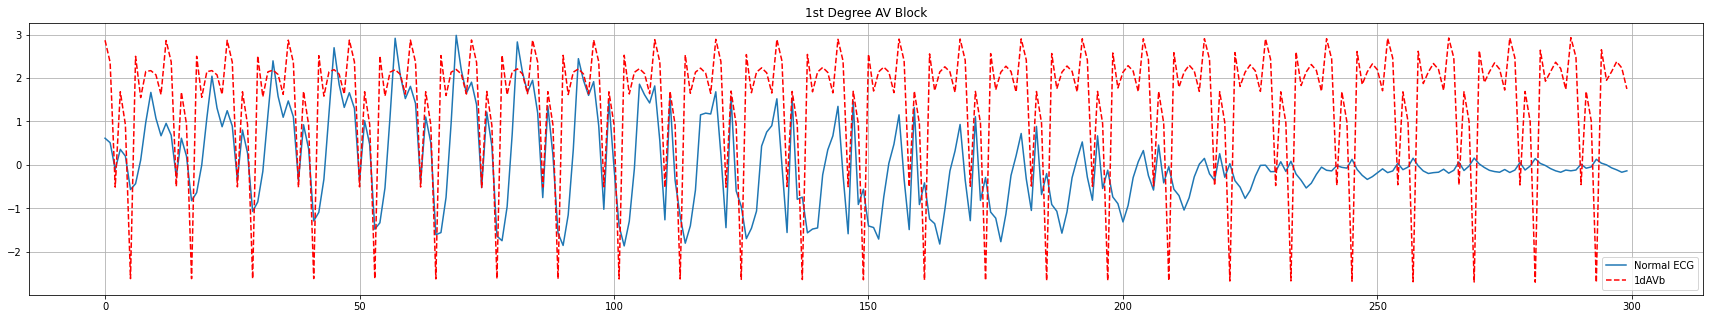

In [ ]:
plt.figure(figsize=(30, 5))
plt.grid()
plt.plot(np.arange(300), X_Test_Nor[0][10800:11100], label='Normal ECG')
plt.plot(np.arange(300), X_Test_dAVb[0][10800:11100], 'r--', label='1dAVb')
plt.title('1st Degree AV Block')
plt.legend()

Il faut corriger des amplitudes pour les avoir toues dans la meme scale 

In [ ]:
# Unify amplitudes to normalize data
min_max_scaler = MinMaxScaler()
X_Train_Nor_s = min_max_scaler.fit_transform(X_Train_Nor)
print('Original Min and Max: {:.1f}, {:.1f}'.format(np.min(X_Train_Nor), np.max(X_Train_Nor)))
print('Original Min and Max: {:.1f}, {:.1f}'.format(np.min(X_Train_Nor_s), np.max(X_Train_Nor_s)))

X_Test_Nor_s = min_max_scaler.transform(X_Test_Nor)
X_Test_dAVb_s = min_max_scaler.transform(X_Test_dAVb)
X_Test_RBBB_s = min_max_scaler.transform(X_Test_RBBB)
X_Test_LBBB_s = min_max_scaler.transform(X_Test_LBBB)
X_Test_SB_s = min_max_scaler.transform(X_Test_SB)
X_Test_AF_s = min_max_scaler.transform(X_Test_AF)
X_Test_ST_s = min_max_scaler.transform(X_Test_ST)

Original Min and Max: -27.8, 56.4
Original Min and Max: 0.0, 1.0


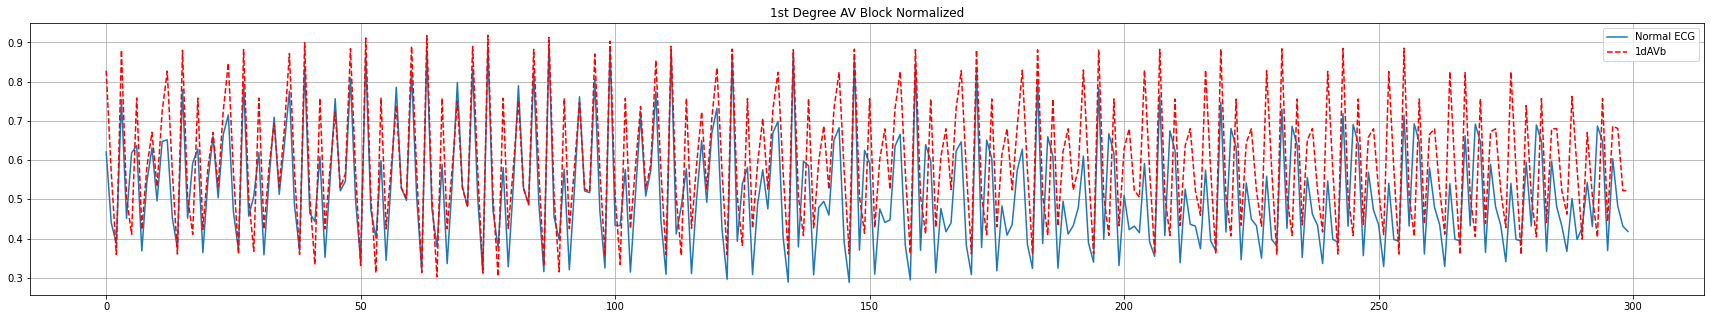

In [ ]:
plt.figure(figsize=(30, 5))
plt.grid()
plt.plot(np.arange(300), X_Test_Nor_s[0][10800:11100], label='Normal ECG')
plt.plot(np.arange(300), X_Test_dAVb_s[0][10800:11100], 'r--', label='1dAVb')
plt.title('1st Degree AV Block Normalized')
plt.legend()

In [ ]:
entry_dim = X_Train_Nor_s.shape[1]
entry = Input(shape=(entry_dim,))

#Encoder
encoder = Dense(3000, activation = 'relu')(entry)
encoder = Dense(2000, activation = 'relu')(encoder)
encoder = Dense(500, activation = 'relu')(encoder)
encoder = Dense(200, activation = 'relu')(encoder)

#Decoder
decoder = Dense(500, activation='relu')(encoder)
decoder = Dense(2000, activation='relu')(decoder)
decoder = Dense(3000, activation='relu')(decoder)
decoder = Dense(49152, activation='sigmoid')(decoder)

#Autoencoder = entrada + decoder 
autoencoder = Model(inputs=entry, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49152)]           0         
                                                                 
 dense_8 (Dense)             (None, 3000)              147459000 
                                                                 
 dense_9 (Dense)             (None, 2000)              6002000   
                                                                 
 dense_10 (Dense)            (None, 500)               1000500   
                                                                 
 dense_11 (Dense)            (None, 200)               100200    
                                                                 
 dense_12 (Dense)            (None, 500)               100500    
                                                                 
 dense_13 (Dense)            (None, 2000)              1002

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(X_Train_Nor_s, X_Train_Nor_s, 
                          epochs=20, 
                          batch_size=512, 
                          validation_data = (X_Test_Nor_s, X_Test_Nor_s), 
                          shuffle=True)

Epoch 1/20
2/2 [==============================] - 28s 9s/step - loss: 0.1147 - val_loss: 0.1987
Epoch 2/20
2/2 [==============================] - 24s 8s/step - loss: 0.1793 - val_loss: 0.1187
Epoch 3/20
2/2 [==============================] - 25s 9s/step - loss: 0.1114 - val_loss: 0.1254
Epoch 4/20
2/2 [==============================] - 26s 9s/step - loss: 0.1111 - val_loss: 0.0830
Epoch 5/20
2/2 [==============================] - 26s 9s/step - loss: 0.0759 - val_loss: 0.0838
Epoch 6/20
2/2 [==============================] - 25s 9s/step - loss: 0.0732 - val_loss: 0.0583
Epoch 7/20
2/2 [==============================] - 25s 9s/step - loss: 0.0521 - val_loss: 0.0621
Epoch 8/20
2/2 [==============================] - 26s 9s/step - loss: 0.0540 - val_loss: 0.0467
Epoch 9/20
2/2 [==============================] - 25s 9s/step - loss: 0.0418 - val_loss: 0.0399
Epoch 10/20
2/2 [==============================] - 24s 9s/step - loss: 0.0346 - val_loss: 0.0439
Epoch 11/20
2/2 [======================

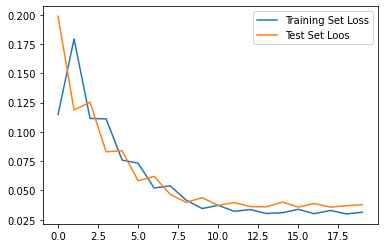

In [ ]:
plt.plot(history.history['loss'], label = 'Training Set Loss')
plt.plot(history.history['val_loss'], label = 'Test Set Loos')
plt.legend()

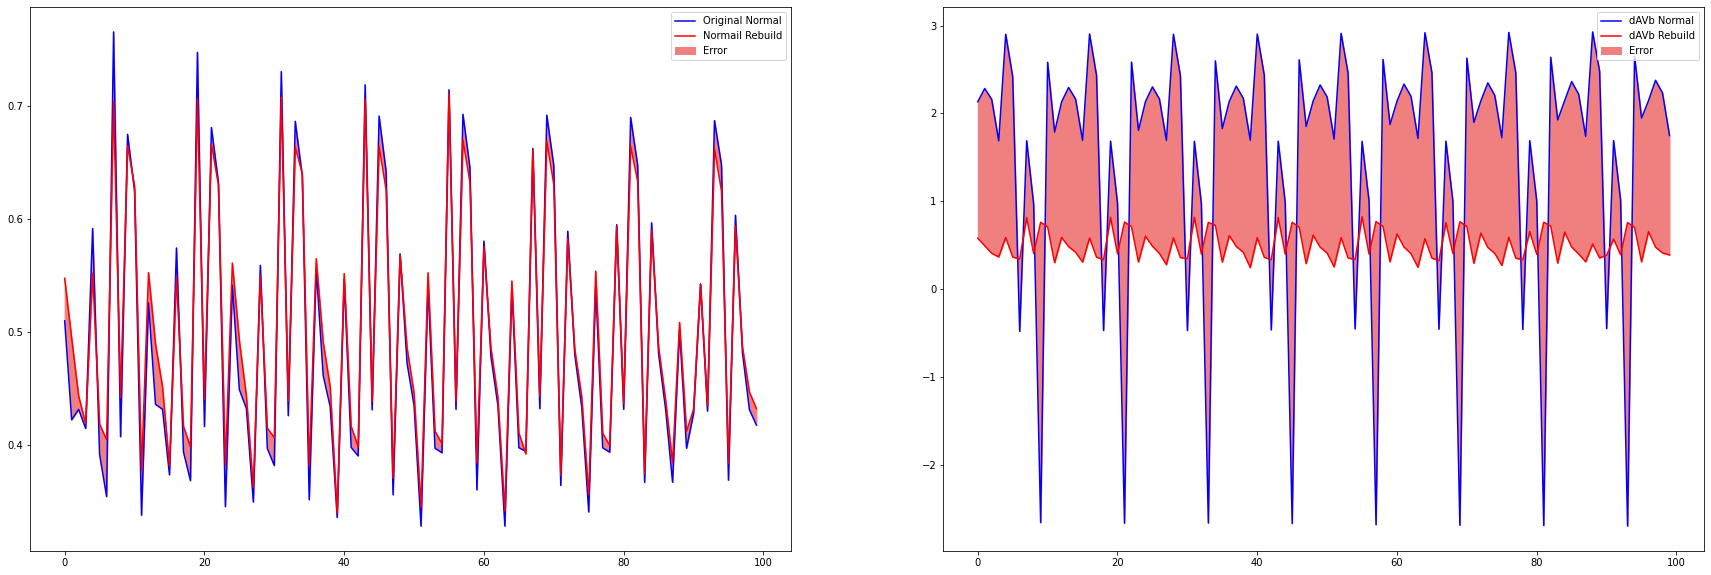

In [ ]:
rec_normal = autoencoder(X_Test_Nor_s).numpy()
rec_not_normal = autoencoder(X_Test_dAVb).numpy()

position = 0
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
plt.plot(X_Test_Nor_s[position][11000:11100], 'b')
plt.plot(rec_normal[position][11000:11100], 'r')
plt.fill_between(np.arange(100), rec_normal[position][11000:11100], X_Test_Nor_s[position][11000:11100], color='lightcoral')
plt.legend(labels=['Original Normal', 'Normail Rebuild', 'Error'])

plt.subplot(1,2,2)
plt.plot(X_Test_dAVb[position][11000:11100], 'b')
plt.plot(rec_not_normal[position][11000:11100], 'r')
plt.fill_between(np.arange(100), rec_not_normal[position][11000:11100], X_Test_dAVb[position][11000:11100], color='lightcoral')
plt.legend(labels=['dAVb Normal', 'dAVb Rebuild', 'Error'])

In [ ]:
rec_normal = autoencoder.predict(X_Test_Nor_s)
rec_dAVb = autoencoder.predict(X_Test_dAVb)
rec_RBBB = autoencoder.predict(X_Test_RBBB)
rec_LBBB = autoencoder.predict(X_Test_LBBB)
rec_SB = autoencoder.predict(X_Test_SB)
rec_AF = autoencoder.predict(X_Test_AF)
rec_ST = autoencoder.predict(X_Test_ST)

loss_normal = tf.keras.losses.mae(rec_normal, X_Test_Nor_s)
loss_dAVb = tf.keras.losses.mae(rec_dAVb, X_Test_dAVb)
loss_RBBB = tf.keras.losses.mae(rec_RBBB, X_Test_RBBB)
loss_LBBB = tf.keras.losses.mae(rec_LBBB, X_Test_LBBB)
loss_SB = tf.keras.losses.mae(rec_SB, X_Test_SB)
loss_AF = tf.keras.losses.mae(rec_AF, X_Test_AF)
loss_ST = tf.keras.losses.mae(rec_ST, X_Test_ST)

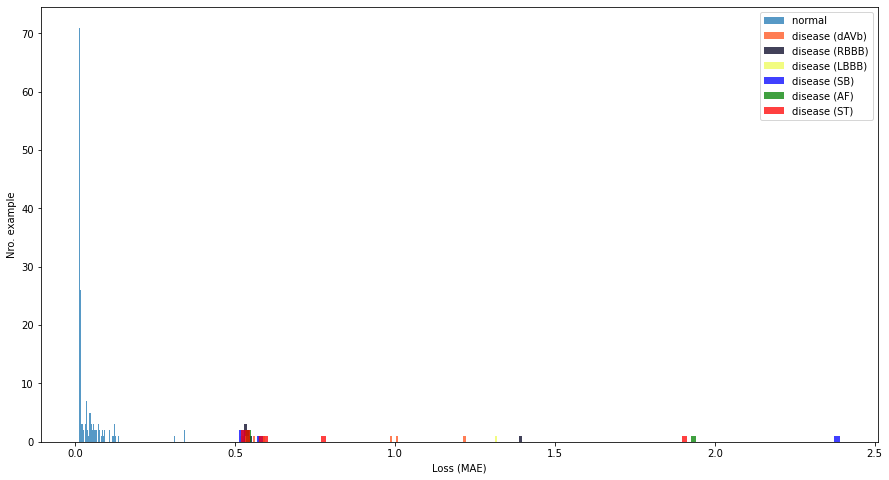

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(loss_normal[None,:], bins=100, alpha=0.75, label='normal ')
plt.hist(loss_dAVb[None,:], bins=100, alpha=0.75, color='#ff521b', label='disease (dAVb)')
plt.hist(loss_RBBB[None,:], bins=100, alpha=0.75, color='#020122', label='disease (RBBB)')
plt.hist(loss_LBBB[None,:], bins=100, alpha=0.75, color='#eefc57', label='disease (LBBB)')
plt.hist(loss_SB[None,:], bins=100, alpha=0.75, color='blue', label='disease (SB)')
plt.hist(loss_AF[None,:], bins=100, alpha=0.75, color='green', label='disease (AF)')
plt.hist(loss_ST[None,:], bins=100, alpha=0.75, color='r', label='disease (ST)')
plt.xlabel('Loss (MAE)')
plt.ylabel('Nro. example')
plt.legend(loc='upper right')
#plt.vlines(0.08,0,70,'k')

In [ ]:
umbral = np.mean(loss_normal) + np.std(loss_normal)
print("Umbral: ", umbral)

Umbral:  0.08829719079805691


In [ ]:
def predecir(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

def calcular_sensitividad(prediccion, titulo):
  TP = np.count_nonzero(~prediccion)
  FN = np.count_nonzero(prediccion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.1f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
  TN = np.count_nonzero(prediccion)
  FP = np.count_nonzero(~prediccion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.1f}%'.format(esp))
  return esp

In [ ]:
pred_1 = predecir(autoencoder, X_Test_Nor_s, umbral)
pred_2 = predecir(autoencoder, X_Test_dAVb, umbral)
pred_3 = predecir(autoencoder, X_Test_RBBB, umbral)
pred_4 = predecir(autoencoder, X_Test_LBBB, umbral)
pred_5 = predecir(autoencoder, X_Test_SB, umbral)
pred_6 = predecir(autoencoder, X_Test_AF, umbral)
pred_7 = predecir(autoencoder, X_Test_ST, umbral)

# Pred1: especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. 1, normales)')

# Pred 2 a 5: sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. 2, anormales)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. 3, anormales)')
sen_4 = calcular_sensitividad(pred_4,'Sensitividad (cat. 4, anormales)')
sen_5 = calcular_sensitividad(pred_5,'Sensitividad (cat. 5, anormales)')
sen_6 = calcular_sensitividad(pred_6,'Sensitividad (cat. 6, anormales)')
sen_7 = calcular_sensitividad(pred_7,'Sensitividad (cat. 7, anormales)')



Especificidad (cat. 1, normales): 90.6%
Sensitividad (cat. 2, anormales): 100.0%
Sensitividad (cat. 3, anormales): 100.0%
Sensitividad (cat. 4, anormales): 100.0%
Sensitividad (cat. 5, anormales): 100.0%
Sensitividad (cat. 6, anormales): 100.0%
Sensitividad (cat. 7, anormales): 100.0%


In [ ]:
labels